In [ ]:
"""
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [119]:
%load_ext autoreload
%autoreload 2
import cil
from cil.utilities.display import show2D
print(f'cil.__version__ = {cil.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cil.__version__ = 24.3.0


In [120]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from util.pcaReader import read_pca_file

filepath = '../CT_pine_cone_hz_8W_200ms/pine_cone.pca'
params = read_pca_file(filepath)
params

196 lines, found 143 values (discarded 124)


{'Version-pca': '2\n',
 'FDD': 648.629315,
 'FOD': 152.7905,
 'CalibValue': 0.0,
 'cx': 499.5,
 'cy': 499.5,
 'DetectorRot': 0.0,
 'Tilt': 0.0,
 'NumberImages': 1080,
 'StartImg': 1081,
 'RotationSector': 360.0,
 'NumberImagesCalib': 18,
 'DimX': 1000.0,
 'DimY': 1000.0,
 'FreeRay': 10552,
 'PixelsizeX': 0.2,
 'PixelsizeY': 0.2,
 'Voltage': 100.0,
 'Current': 80.0}

In [121]:
from util.getParameters import get_ct_parameters

SOD,\
SDD,\
ODD,\
pixel_size,\
num_pixels,\
num_projs,\
intensity = get_ct_parameters(params)

SOD: 152.791 mm
SDD: 648.629 mm
ODD: 495.839 mm
Detector pixel size: 0.200 mm
Projection image size: 1000 x 1000
1080 projection angles used
White level intensity: 10552


In [122]:
from util.setAcquisitionGeometry import set_ct_acquisition_geometry

ag = set_ct_acquisition_geometry(params=params)

SOD: 152.791 mm
SDD: 648.629 mm
ODD: 495.839 mm
Detector pixel size: 0.200 mm
Projection image size: 1000 x 1000
1080 projection angles used
White level intensity: 10552
3D Cone-beam tomography
System configuration:
	Source position: [   0.    , -152.7905,    0.    ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.      , 495.838815,   0.      ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 108
	Angles 0-9 in degrees: [ 0.       ,  3.3333333,  6.6666665, 10.       , 13.333333 , 16.666666 ,
 20.       , 23.333334 , 26.666666 , 30.       ]
	Angles 98-107 in degrees: [326.66666, 330.     , 333.33334, 336.66666, 340.     , 343.33334,
 346.66666, 350.     , 353.33334, 356.66666]
	Full angular array can be accessed with 

Number of dimensions: 3
Shape: (108, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



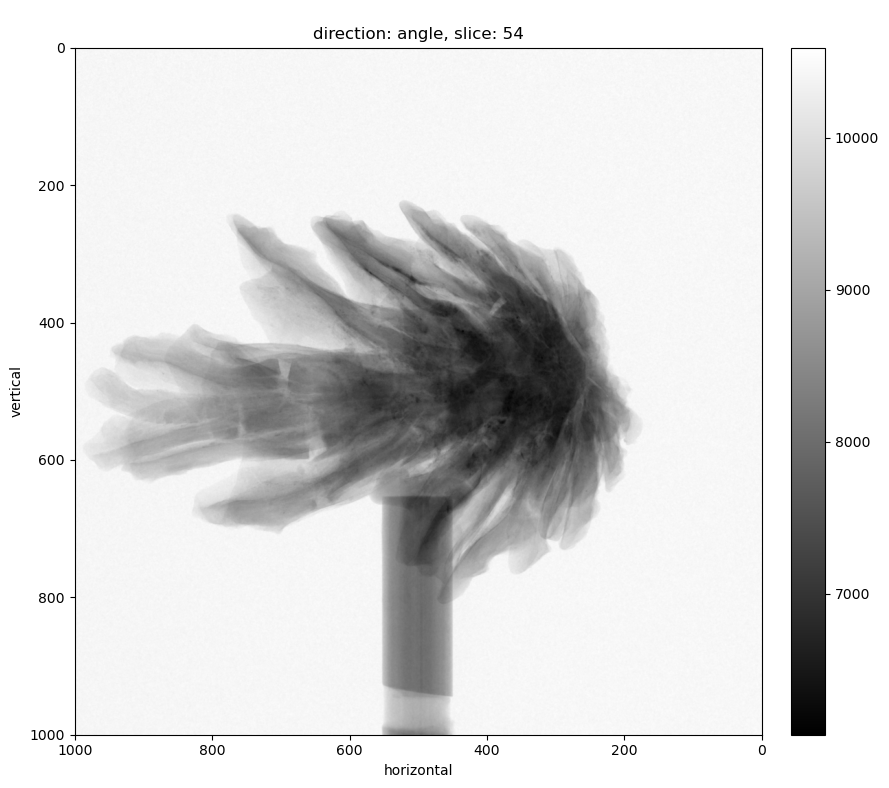

In [123]:
from util.readData import read_ct_data

trans_data = read_ct_data(
    filename='../CT_pine_cone_hz_8W_200ms',
    acquisition_geometry=ag
    )

white_level = 10552, about 64.404 of the maximum (of 14 bit int)


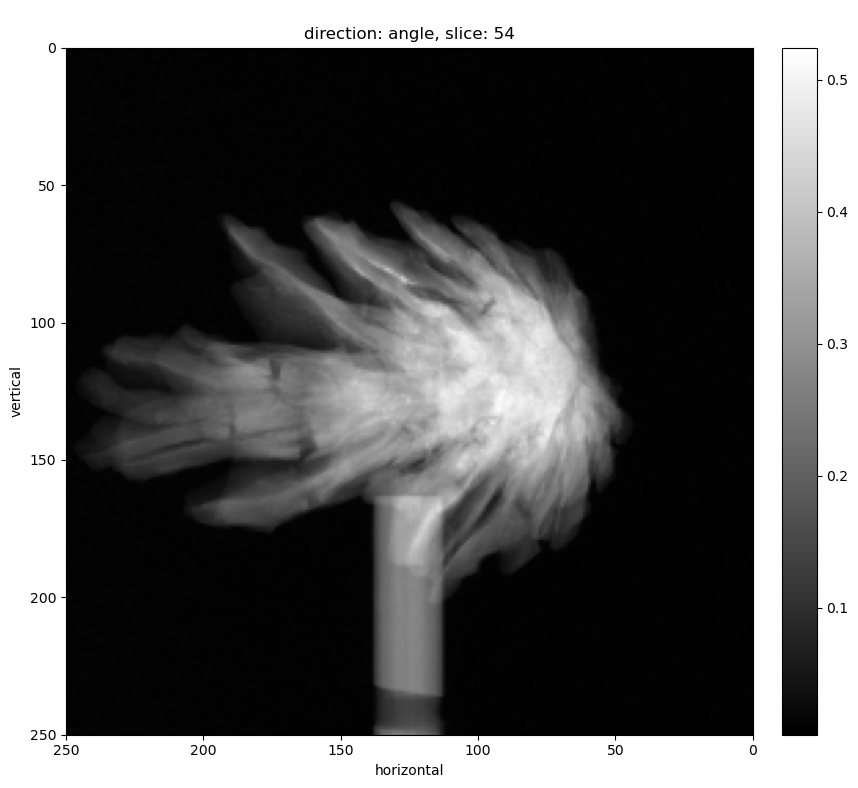

Number of dimensions: 3
Shape: (108, 250, 250)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [124]:
from util.convertData import convert_ct_data

abs_data = convert_ct_data(trans_data, white_level=intensity)

In [125]:
from cil.utilities.jupyter import islicer

islicer(abs_data)

In [60]:
del trans_data

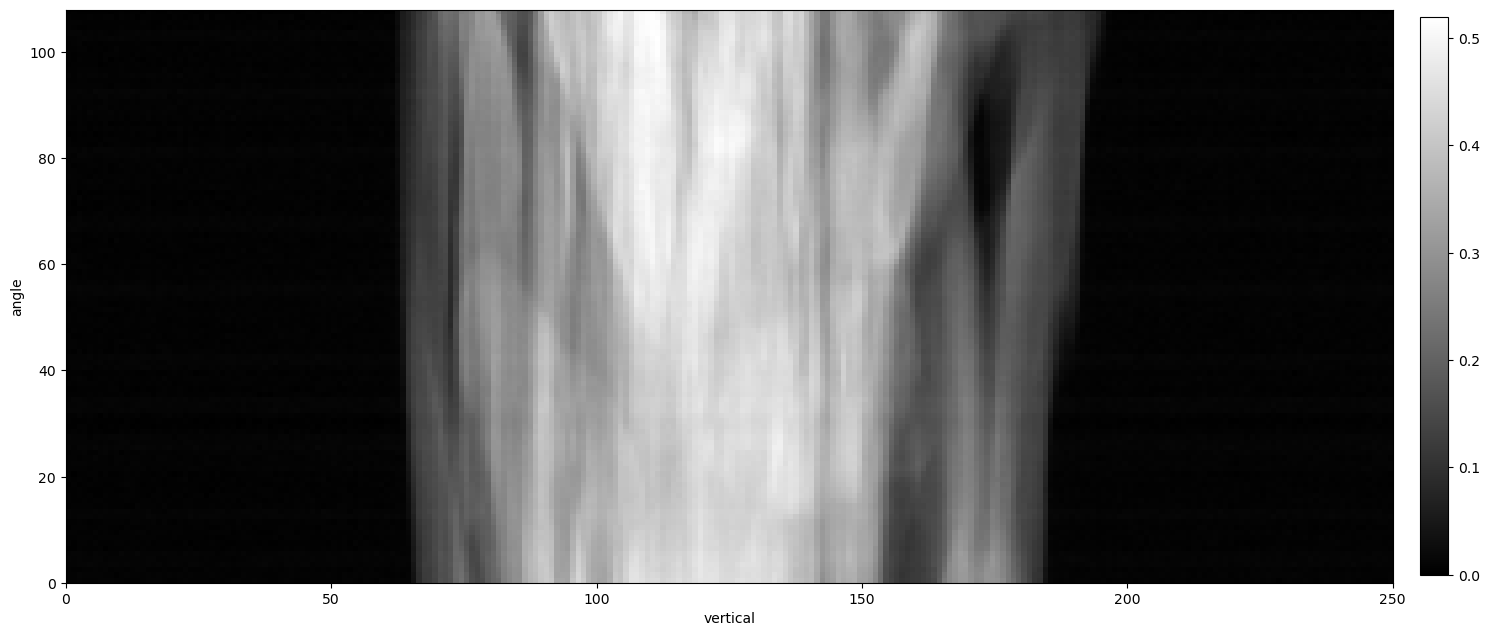

In [127]:
sino = abs_data.get_slice(horizontal=100, force=True)
# sino = abs_data.get_slice(vertical=100, force=True)
show2D(sino)

Rebinning is complete.
Shape of the parallel-beam sinogram: (247, 55).
Shape of the parallel-beam sensor locations vector: (247,)
Shape of the parallel-beam angles: (55,).


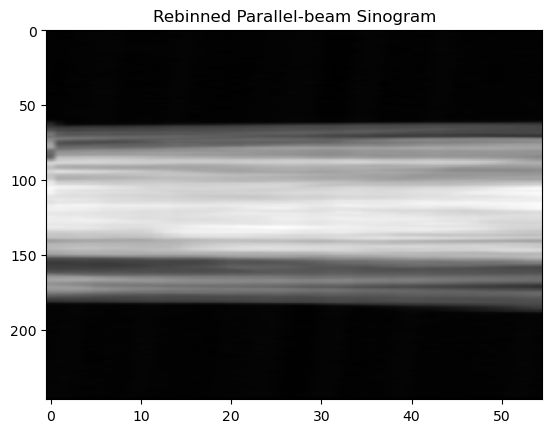

In [128]:
from util.fanToPara import convert_fan_to_parallel_geometry
index = 100
para_sinogram, para_loc, para_angles = convert_fan_to_parallel_geometry(data=abs_data, idx=index, source_origin_distance=SOD, direction=True)

In [ ]:
# import h5py

# output_file = 'pine_cone_sinogram_idx_100.h5'

# with h5py.File(output_file, 'w') as f:
#     f.create_dataset('pine_cone_sinogram', data=para_sinogram.T)
#     f.create_dataset('para_angles', data=para_angles)

# !mv 'pine_cone_sinogram_idx_100.h5' '/home/santtalainen/KernelTomoRecons/simul/'

In [ ]:
# import numpy as np
# np.save(f"pine_cone_sinogram_{index}.npy", para_sinogram)
# np.save(f"para_loc_{index}.npy", para_loc)
# np.save(f"para_angles_{index}.npy", para_angles)
# !mv pine_cone_sinogram_{index}.npy para_loc_{index}.npy para_angles_{index}.npy /home/santtalainen/Reconstructions/KernelCT/Data/

Reconstruction complete.


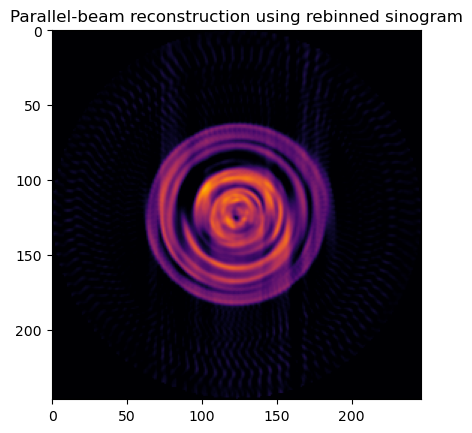

In [130]:
from util.fanToPara import reconstruct_parallel_sinogram

recon = reconstruct_parallel_sinogram(
    parallel_sinogram=para_sinogram,
    parallel_angles=para_angles,
    filter_name='hann',
    interpolation='linear',
    lower_bound=0,
    upper_bound=0.01,
    cmap='inferno')

In [131]:
# Setup for the image geometry
(_, nz, nx) = abs_data.shape

# Image geometry
ig = abs_data.geometry.get_ImageGeometry()
ig.voxel_num_x = nx
ig.voxel_num_y = nx
ig.voxel_num_z = nz
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x250,y250,z250
voxel_size : x0.18844723353276133,y0.18844723353276133,z0.18844723353276133
center : x0,y0,z0



In [132]:

from cil.recon import FDK

# data.reorder('tigre')
abs_data.reorder('tigre')
fdk = FDK(abs_data, image_geometry=ig, filter='ram-lak')
fdk_recon = fdk.run()

FDK recon

Input Data:
	angle: 108
	vertical: 250
	horizontal: 250

Reconstruction Volume:
	vertical: 250
	horizontal_y: 250
	horizontal_x: 250

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False



(250, 250, 250)


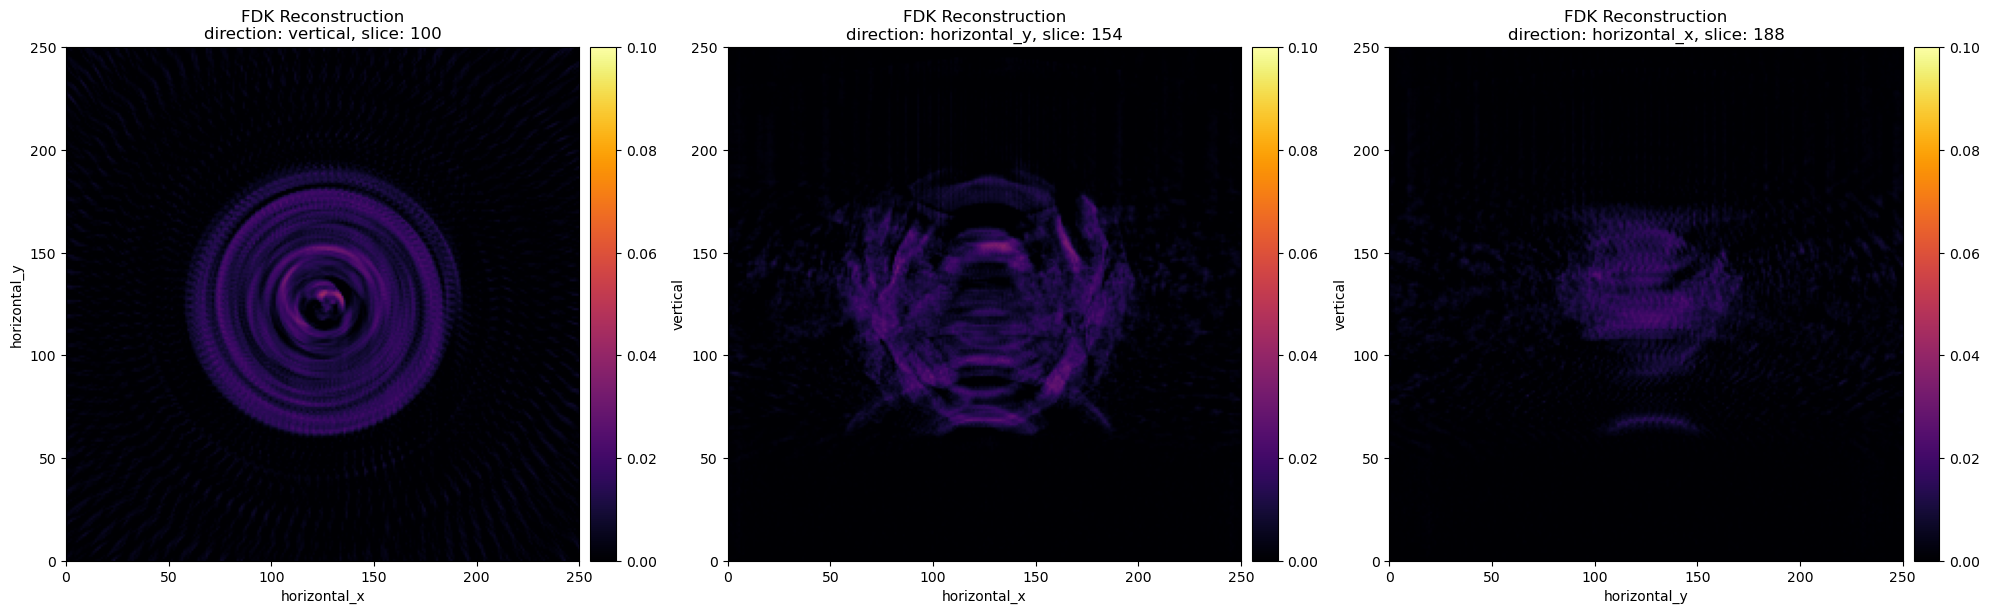

In [133]:
lb = 0 # lower bound
ub = .1 # upper bound
print(fdk_recon.shape)
show2D(fdk_recon, size=(20,10), fix_range=(lb,ub), cmap='inferno', title=f'FDK Reconstruction', num_cols=3, slice_list=[(0, 100), (1, 154), (2, 188)]);

In [73]:
islicer(fdk_recon, minmax=(0,0.1), direction=0, cmap='inferno')